In [3]:
import pandas as pd
import numpy as np

In [4]:
data='https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [5]:
!wget $data

--2025-10-21 01:38:41--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.1’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.06s   

2025-10-21 01:38:42 (1.26 MB/s) - ‘course_lead_scoring.csv.1’ saved [80876/80876]



In [7]:
df=pd.read_csv('course_lead_scoring.csv.1')

In [8]:
df.head(5)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [9]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [10]:
#no of null values in each column
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [11]:
#target variable is converted
df.converted.value_counts()

converted
1    905
0    557
Name: count, dtype: int64

In [13]:
# Identify categorical and numerical columns
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Fill missing values
df[cat_cols] = df[cat_cols].fillna('NA')
df[num_cols] = df[num_cols].fillna(0.0)


In [41]:
num_cols

Index(['number_of_courses_viewed', 'annual_income', 'interaction_count',
       'lead_score', 'converted'],
      dtype='object')

In [14]:
X = df.drop('converted', axis=1)   # Features
y = df['converted']                # Target: "1"/"0" (client converted or not)

In [15]:
from sklearn.model_selection import train_test_split

# First, split into 60% train and 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)

# Then split the temp (40%) into 20% validation and 20% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

# Verify proportions
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")


Train size: 877
Validation size: 292
Test size: 293


In [16]:
from sklearn.metrics import roc_auc_score

# List of numerical variables
num_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

auc_results = {}

for col in num_vars:
    auc = roc_auc_score(y_train, X_train[col])
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[col])
        direction = 'inverted'
    else:
        direction = 'normal'
    
    auc_results[col] = (auc, direction)

# Display results
for col, (auc, direction) in auc_results.items():
    print(f"{col}: AUC = {auc:.4f} ({direction})")


lead_score: AUC = 0.6107 (normal)
number_of_courses_viewed: AUC = 0.7648 (normal)
interaction_count: AUC = 0.7227 (normal)
annual_income: AUC = 0.5545 (normal)


In [17]:
#1Which numerical variable (among the following 4) has the highest AUC?

#lead_score
#number_of_courses_viewed
#interaction_count
#annual_income

best_var = max(auc_results, key=lambda k: auc_results[k][0])
best_auc, best_dir = auc_results[best_var]

print("Feature with highest AUC:")
print(f"{best_var}: AUC = {best_auc:.4f} ({best_dir})")

Feature with highest AUC:
number_of_courses_viewed: AUC = 0.7648 (normal)


In [44]:


from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Convert train/validation dataframes to list of dictionaries
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

# Initialize and apply one-hot encoding
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)

# Train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

# Predict probabilities on validation set
y_pred_val = model.predict_proba(X_val_encoded)[:, 1]

# Compute AUC
auc_val = roc_auc_score(y_val, y_pred_val)
print(f"Validation AUC: {auc_val:.3f}")


Validation AUC: 0.866


In [52]:
#What's the AUC of this model on the validation dataset? (round to 3 digits)

#0.32
#0.52
#0.72
#0.92

0.92

0.92

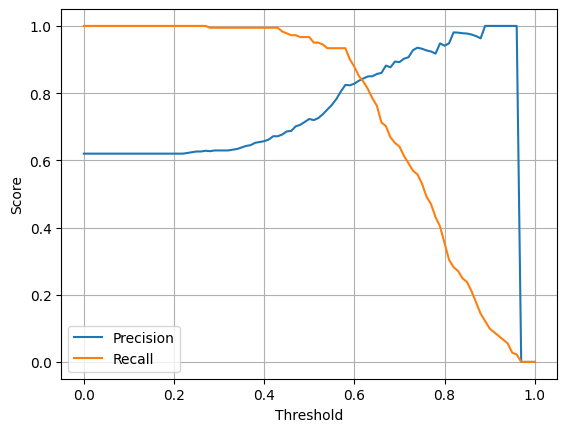

Precision and Recall intersect around threshold = 0.616


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Use predicted probabilities from your logistic regression model
y_scores = model.predict_proba(X_val_encoded)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
precision_list = []
recall_list = []

# Compute precision and recall for each threshold
for t in thresholds:
    y_pred = (y_scores >= t).astype(int)
    # safe precision/recall; if no predicted positives, precision=0 by sklearn default
    precision_list.append(precision_score(y_val, y_pred, zero_division=0))
    recall_list.append(recall_score(y_val, y_pred))

# Plot precision vs recall curves
plt.figure()
plt.plot(thresholds, precision_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# ---- Find intersection(s) and pick the middle one ----
p = np.array(precision_list, dtype=float)
r = np.array(recall_list, dtype=float)
d = p - r  # sign change => crossing

# Indices where sign changes between consecutive thresholds
sign = np.sign(d)
cross_idx = np.where(sign[:-1] * sign[1:] <= 0)[0]  # includes exact zeros

crossings = []
for i in cross_idx:
    # Linear interpolate to approximate where d crosses 0 between thresholds[i] and thresholds[i+1]
    d0, d1 = d[i], d[i+1]
    t0, t1 = thresholds[i], thresholds[i+1]
    if d1 != d0:
        t_cross = t0 + (0 - d0) * (t1 - t0) / (d1 - d0)
    else:
        # rare: both equal; take midpoint
        t_cross = 0.5 * (t0 + t1)
    crossings.append(t_cross)

if len(crossings) == 0:
    # Fallback: choose threshold where |precision - recall| is minimized,
    # but prefer the middle region to avoid tails.
    mid_mask = (thresholds >= 0.2) & (thresholds <= 0.8)
    diffs = np.abs(d)
    if mid_mask.any():
        best_idx = np.argmin(diffs[mid_mask])
        best_threshold = thresholds[mid_mask][best_idx]
    else:
        best_threshold = thresholds[np.argmin(diffs)]
else:
    # Pick the crossing closest to 0.5 (the “middle” one)
    crossings = np.array(crossings)
    best_threshold = crossings[np.argmin(np.abs(crossings - 0.5))]

print(f"Precision and Recall intersect around threshold = {best_threshold:.3f}")


In [54]:
#At which threshold precision and recall curves intersect?

#0.145
#0.345
#0.545
#0.745

0.545

0.545

In [46]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

# Reuse predicted probabilities
y_scores = model.predict_proba(X_val_encoded)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
f1_list = []

for t in thresholds:
    y_pred = (y_scores >= t).astype(int)
    P = precision_score(y_val, y_pred, zero_division=0)
    R = recall_score(y_val, y_pred)
    if (P + R) == 0:
        f1 = 0
    else:
        f1 = 2 * P * R / (P + R)
    f1_list.append(f1)

# Find best threshold
best_idx = np.argmax(f1_list)
best_threshold = thresholds[best_idx]
best_f1 = f1_list[best_idx]

print(f"Best F1 = {best_f1:.3f} at threshold = {best_threshold:.3f}")


Best F1 = 0.876 at threshold = 0.580


In [55]:
#Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

#At which threshold F1 is maximal?

#0.14
#0.34
#0.54
#0.74

0.54

0.54

In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# df_full_train is your full training frame (features + target)
df_full_train = df.copy()
# target column name:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

target = 'converted'
y = df_full_train[target].astype(int).values
X = df_full_train.drop(columns=[target])

kf = KFold(n_splits=5, shuffle=True, random_state=1)
aucs = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    dv = DictVectorizer(sparse=False)
    X_train_enc = dv.fit_transform(X_train.to_dict(orient='records'))
    X_val_enc = dv.transform(X_val.to_dict(orient='records'))

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_enc, y_train)

    y_pred = model.predict_proba(X_val_enc)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)

print('AUCs per fold:', aucs)
print('Mean AUC:', np.mean(aucs))
print('Std of AUC:', np.std(aucs))


AUCs per fold: [0.8172202350536536, 0.7792846497764531, 0.8309278350515464, 0.8675988428158148, 0.8093413173652695]
Mean AUC: 0.8208745760125474
Std of AUC: 0.028845510405609943


In [57]:
#How large is standard deviation of the scores across different folds?

#0.0001
#0.006
#0.06
#0.36

0.06

0.06

In [50]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# features & target
target = 'converted'
y = df_full_train[target].astype(int).values
X = df_full_train.drop(columns=[target])

# 5-fold CV setup
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# C values to test
C_values = [0.000001, 0.001, 1]

for C in C_values:
    aucs = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        dv = DictVectorizer(sparse=False)
        X_train_enc = dv.fit_transform(X_train.to_dict(orient='records'))
        X_val_enc = dv.transform(X_val.to_dict(orient='records'))

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_enc, y_train)

        y_pred = model.predict_proba(X_val_enc)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    print(f"C={C:<10} Mean AUC={mean_auc:.3f}  Std={std_auc:.3f}")


C=1e-06      Mean AUC=0.549  Std=0.030
C=0.001      Mean AUC=0.862  Std=0.024
C=1          Mean AUC=0.821  Std=0.029


In [58]:
#Which C leads to the best mean score?

#0.000001
#0.001
#1

1

1